In [1]:

!pip install tokenizers>=0.19.0 transformers>=4.40.0
!pip install timm textaugment pandas pillow torch torchvision
!pip install git+https://github.com/RyanWangZf/MedCLIP.git --no-deps
!pip install wget

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 76.9 MB/s eta 0:00:00
  Cloning https://github.com/RyanWangZf/MedCLIP.git to /tmp/pip-req-build-o3kojr2d
  Running command git clone --filter=blob:none --quiet https://github.com/RyanWangZf/MedCLIP.git /tmp/pip-req-build-o3kojr2d
  Resolved https://github.com/RyanWangZf/MedCLIP.git to commit 9c3396f20d5d54e4fae241b8cb06ca45848e98c9
  Preparing metadata (setup.py) ... done
  Created wheel for MedCLIP: filename=MedCLIP-0.0.3-py3-none-any.whl size=28011 sha256=e4d5a183f614881c07785d1e8619870ed3b82f8e26966a76f35a92192b17fc41
  Stored in directory: /tmp/pip-ephem-wheel-cache-e1_frkf8/wheels/2b/93/ea/986fa72399d1632802a7e930f1b4a0c55151c5ba68ef9a3a32
Successfully built MedCLIP
  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9655 sha256=385c5771365440cee32d6c7f41d4951004b8372e508c293df0e7015301e28da3
  Stored in directory: /root/.cache/pip/wheels/01/46/3b/e29ffbe4ebe614ff224bad4

In [9]:
import medclip
from medclip import MedCLIPModel, MedCLIPProcessor
import torch
import os
import zipfile
import requests
from torchvision import transforms
from PIL import Image
import requests
import matplotlib.pyplot as plt
import io


In [26]:

#configuration des chemins
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
zip_path = "medclip-pretrained.zip"
extract_path = "./pretrained"
model_file = os.path.join(extract_path, "pytorch_model.bin")

try:
    #vu que nous n'avons pas élécgarger M le fichier du gars on a opté de le télécharger manuellement #M
    if not os.path.exists(model_file):
        print("Téléchargement du modèle...")
        url = "https://storage.googleapis.com/pytrial/medclip-pretrained.zip"
        r = requests.get(url, allow_redirects=True)
        with open(zip_path, 'wb') as f:
            f.write(r.content)

        #décompression
        print("Décompression...")
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(extract_path)
        print("Téléchargement terminé.")

    #initialisation du modèle
    model = MedCLIPModel()

    #chargement des poids avec strict=False parce que le true ne fonctionne pas avec la version python qu'on utilise
    state_dict = torch.load(model_file, map_location=device)
    model.load_state_dict(state_dict, strict=False)

    model.to(device)
    model.eval()

    processor = MedCLIPProcessor()
    print(f"MedCLIP est prêt sur {device} !")

except Exception as e:
    print(f"Erreur : {e}")

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.12/dist-packages/transformers/models/clip/feature_extraction_clip.py:30: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(


MedCLIP est prêt sur cuda !


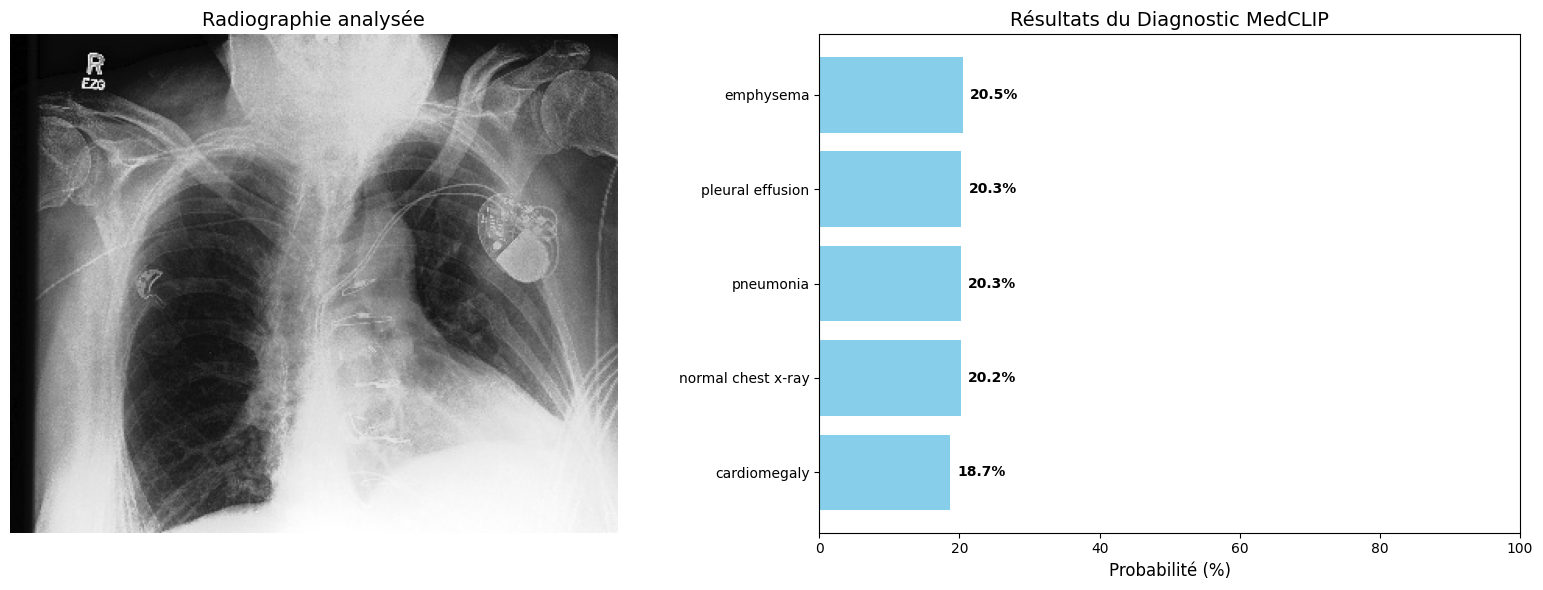

In [27]:
def firstTestMedclip(img_path_or_url, labels):
    #chargement de l'image
    if img_path_or_url.startswith('http'):
        img = Image.open(requests.get(img_path_or_url, stream=True).raw).convert('RGB')
    else:
        img = Image.open(img_path_or_url).convert('RGB')

    #prétraitement
    pixel_values = preprocess(img).unsqueeze(0).to(device)
    tokens = processor.tokenizer(text=labels, return_tensors="pt", padding=True, truncation=True).to(device)

    #inférence A
    model.eval()
    with torch.no_grad():
        outputs = model(
            input_ids=tokens['input_ids'],
            attention_mask=tokens['attention_mask'],
            pixel_values=pixel_values
        )

        if hasattr(outputs, 'logits_per_image'):
            logits_per_image = outputs.logits_per_image
        else:
            vision_embeds = outputs.img_embeds if hasattr(outputs, 'img_embeds') else outputs['img_embeds']
            text_embeds = outputs.text_embeds if hasattr(outputs, 'text_embeds') else outputs['text_embeds']
            logits_per_image = vision_embeds @ text_embeds.t()

        probs = logits_per_image.softmax(dim=-1).cpu().numpy()[0]

    #préparation des données pour le graphique (Tri croissant pour barh)
    results = sorted(zip(labels, probs), key=lambda x: x[1])
    sorted_labels = [r[0] for r in results]
    sorted_probs = [r[1] * 100 for r in results]

    #visualisation graphique
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    #affichage de l'image
    ax1.imshow(img)
    ax1.set_title("Radiographie analysée", fontsize=14)
    ax1.axis('off')

    #affichage du graphique à barres
    bars = ax2.barh(sorted_labels, sorted_probs, color='skyblue')
    ax2.set_xlabel('Probabilité (%)', fontsize=12)
    ax2.set_title('Résultats du Diagnostic MedCLIP', fontsize=14)
    ax2.set_xlim(0, 100) # Échelle de 0 à 100%

    #ajout des étiquettes de pourcentage sur les barres
    for bar in bars:
        width = bar.get_width()
        ax2.text(width + 1, bar.get_y() + bar.get_height()/2,
                 f'{width:.1f}%', va='center', fontsize=10, fontweight='bold')

    plt.tight_layout()
    plt.show()
#test
test_url = "https://raw.githubusercontent.com/RyanWangZf/MedCLIP/main/example_data/view1_frontal.jpg"
my_labels = ["cardiomegaly", "pneumonia", "pleural effusion", "normal chest x-ray", "emphysema"]

firstTestMedclip(test_url, my_labels)

nous avons remarquer ici que le modèle a du mal  à faire une bonne distribution des probalités

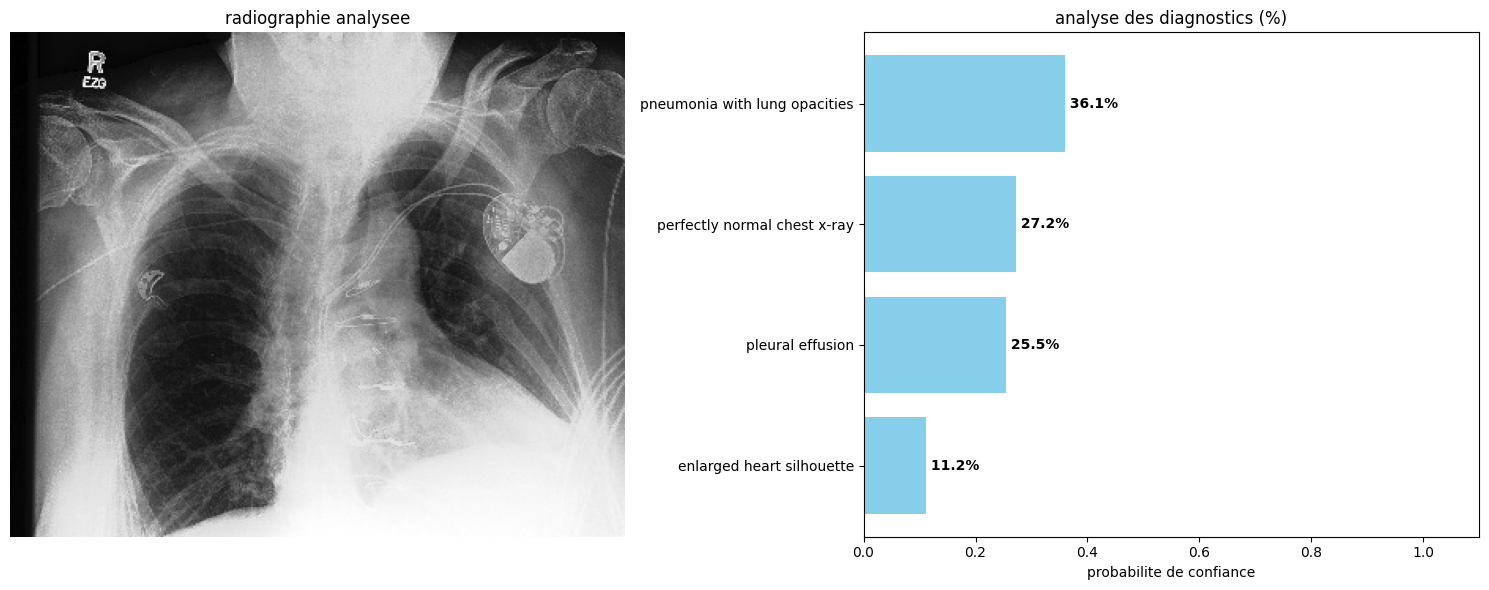

In [28]:
def finalTestMedclip_Visual(img_path_or_url, labels):
    #chargement de l'image M
    if img_path_or_url.startswith('http'):
        img = Image.open(requests.get(img_path_or_url, stream=True).raw).convert('RGB')
    else:
        img = Image.open(img_path_or_url).convert('RGB')
    #pretraitement image & texte #M
    pixel_values = preprocess(img).unsqueeze(0).to(device)
    tokens = processor.tokenizer(text=labels, return_tensors="pt", padding=True, truncation=True).to(device)
    with torch.no_grad():
        #extraction des caracteristiques
        outputs = model(
            input_ids=tokens['input_ids'],
            attention_mask=tokens['attention_mask'],
            pixel_values=pixel_values
        )
        #recuperation des vecteurs
        vision_embeds = outputs.img_embeds if hasattr(outputs, 'img_embeds') else outputs['img_embeds']
        text_embeds = outputs.text_embeds if hasattr(outputs, 'text_embeds') else outputs['text_embeds']
        #normalisation pour la similarite cosinus
        vision_embeds = vision_embeds / vision_embeds.norm(dim=-1, keepdim=True)
        text_embeds = text_embeds / text_embeds.norm(dim=-1, keepdim=True)

        #calcul de l echelle (logit_scale)
        if hasattr(model, 'logit_scale'):
            logit_scale = model.logit_scale.exp()
        else:
            logit_scale = 100.0
        #calcul des probabilites
        logits_per_image = (vision_embeds @ text_embeds.t()) * logit_scale
        probs = logits_per_image.softmax(dim=-1).cpu().numpy()[0]
    #création de la figure matplotlib avec deux zones (image et graphique) A
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    #affichage de l'image de la radio
    ax1.imshow(img, cmap='bone')
    ax1.set_title("radiographie analysee")
    ax1.axis('off')
    #préparation des donnees triees pour le graphique
    results = sorted(zip(labels, probs), key=lambda x: x[1])
    sorted_labels = [r[0] for r in results]
    sorted_probs = [r[1] for r in results]
    #dessin du graphique a barres horizontales
    bars = ax2.barh(sorted_labels, sorted_probs, color='skyblue')
    ax2.set_xlabel('probabilite de confiance')
    ax2.set_title('analyse des diagnostics (%)')
    ax2.set_xlim(0, 1.1)
    #ajout des pourcentages au bout des barres pour la clarte
    for bar in bars:
        width = bar.get_width()
        ax2.text(width, bar.get_y() + bar.get_height()/2, f' {width*100:.1f}%', va='center', fontweight='bold')

    plt.tight_layout()
    plt.show()
my_labels = [
    "enlarged heart silhouette",
    "pneumonia with lung opacities",
    "pleural effusion",
    "perfectly normal chest x-ray"
]

finalTestMedclip_Visual(test_url, my_labels)

Dans le premier teste, le modèle comparait les vecteurs bruts. Ici, nous avons ajouté : vision_embeds = vision_embeds / vision_embeds.norm(dim=-1, keepdim=True) Cela force l'IA à ne regarder que l'angle  entre l'image et le texte, et non leur taille: c'est la similarité cosinus. C'est la méthode standard pour que les modèles de type CLIP fonctionnent correctement. Cepenfdant on voit toujours des que la déision est très faible

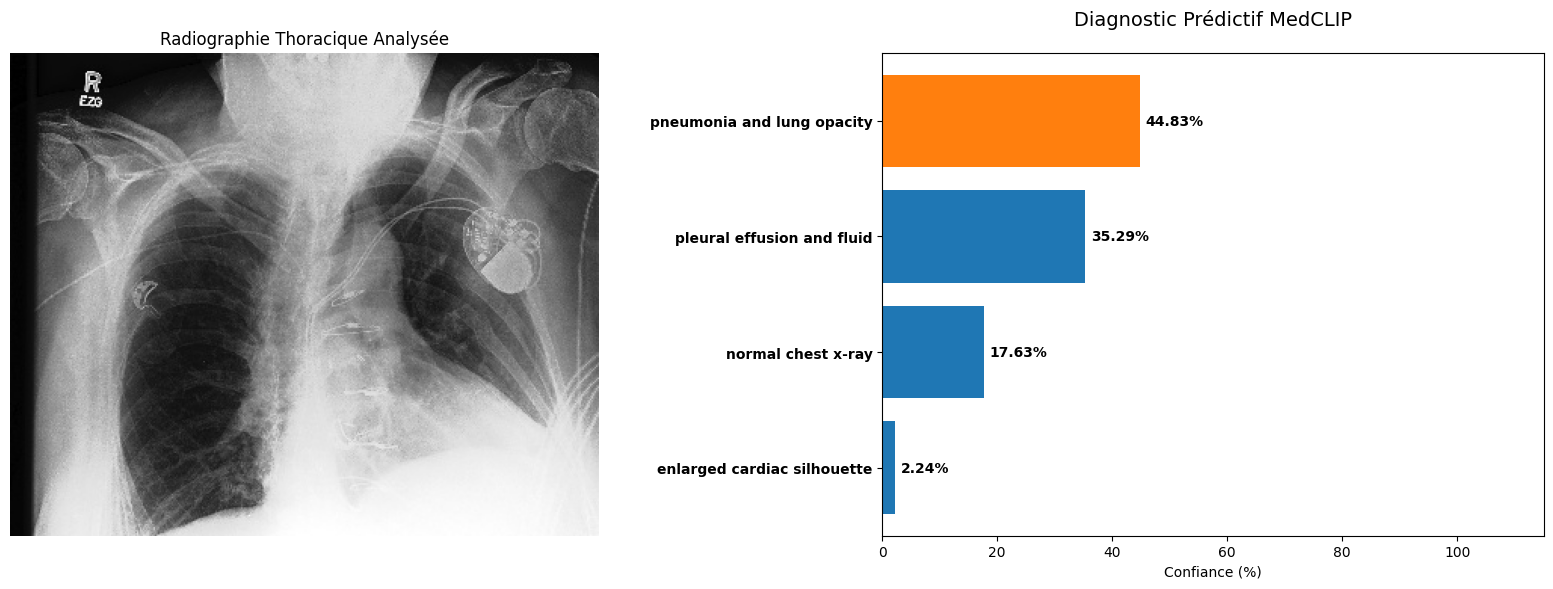

In [29]:
#labels optimisés
labels = [
    "enlarged cardiac silhouette",          #Cardiomégalie
    "pleural effusion and fluid",           #Épanchement pleural
    "pneumonia and lung opacity",           #Pneumonie
    "normal chest x-ray"                    #Normal
]

try:
    #chargement de l'image
    headers = {'User-Agent': 'Mozilla/5.0'}
    response = requests.get(test_url, headers=headers, timeout=10)
    img = Image.open(io.BytesIO(response.content)).convert('RGB')

    #préparation des entrées (Envoi sur GPU) D
    pixel_values = preprocess(img).unsqueeze(0).to(device)
    tokens = processor.tokenizer(text=labels, return_tensors="pt", padding=True, truncation=True).to(device)

    #inférence
    model.to(device)
    model.eval()
    with torch.no_grad():
        outputs = model(input_ids=tokens['input_ids'], attention_mask=tokens['attention_mask'], pixel_values=pixel_values)

        #gestion du format de sortie (Dictionnaire vs Objet)
        if isinstance(outputs, dict):
            img_embeds = outputs['img_embeds']
            text_embeds = outputs['text_embeds']
        else:
            img_embeds = outputs.img_embeds
            text_embeds = outputs.text_embeds

        #normalisation L2
        v_emb = img_embeds / img_embeds.norm(dim=-1, keepdim=True)
        t_emb = text_embeds / text_embeds.norm(dim=-1, keepdim=True)

        #calcul des probabilités (Température de 50) O
        logits = (v_emb @ t_emb.t()) * 50
        probs = logits.softmax(dim=-1).cpu().numpy()[0]

    #triions les données pour le graphique (Le plus haut en haut)
    #on trie par ordre croissant car barh affiche le bas de la liste en haut
    sorted_pairs = sorted(zip(labels, probs), key=lambda x: x[1], reverse=False)
    sorted_labels = [x[0] for x in sorted_pairs]
    sorted_probs = [x[1] for x in sorted_pairs]

    #visualisation pour le Poster
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    #affichage de l'image
    ax1.imshow(img)
    ax1.set_title("Radiographie Thoracique Analysée")
    ax1.axis('off')

    #graphique à barres
    y_pos = range(len(sorted_labels))
    #couleur: Orange pour le résultat le plus probable, bleu pour les autres
    colors = ['#1f77b4'] * (len(sorted_labels) - 1) + ['#ff7f0e']

    bars = ax2.barh(y_pos, [p * 100 for p in sorted_probs], color=colors)
    ax2.set_yticks(y_pos)
    ax2.set_yticklabels(sorted_labels, fontweight='bold')
    ax2.set_xlabel('Confiance (%)')
    ax2.set_title('Diagnostic Prédictif MedCLIP', fontsize=14, pad=20)
    ax2.set_xlim(0, 115) # Place pour le texte

    #ajoutons les labels de pourcentage U
    for i, v in enumerate(sorted_probs):
        ax2.text(v * 100 + 1, i, f"{v*100:.2f}%", va='center', fontweight='bold')

    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"Une erreur est survenue : {e}")

Nous avons d'abord effectué une normalisation L2, qui consiste à diviser chaque vecteur par sa norme pour qu'il ait une longueur de 1, permettant ainsi de mesurer leur similarité par un simple produit scalaire.

Ensuite, nous avons appliqué le logit scale (ou température), un facteur multiplicatif qui amplifie les contrastes entre les scores pour que la fonction Softmax produise des probabilités nettes au lieu de valeurs uniformes.

Maintenant on a vu que le modèle est beaucoup mieux lorsqu'on utilise des mots spécifiques. Par contre toute personnes qui utilisera ce modèle ne peut pas ou n'aura pas la chance de connaitre ces mots et peut alors utiliser leurs synonymes. c'est la raison pour laquelle on va créer une bibliothèque qui permettra de traduire chaque synonyme des mot d'Or, qu'on l'appellera, en ce mot d'Or pour tirer la meilleure partie du programme. On parlera ici de Prompt engineering

In [16]:
#bibliothèque de mots d'OR
golden_Library = {
    "enlarged cardiac silhouette": ["cardiomegalie", "gros coeur", "enlarged heart", "grosse patate"],
    "blunted costophrenic angle": ["epanchement pleural", "liquide dans les poumons", "pleural effusion"],
    "pleural line and collapsed lung": ["pneumothorax", "decollement de la plevre", "poumon affaisse", "collapsed lung"],
    "no active disease": ["normal", "sain", "pas de maladie", "tout va bien"]
}

def getGoldenWord(simpleWord):
    simpleWord = simpleWord.lower().strip()
    for goldenWord, synonyms in golden_Library.items():
        if simpleWord in synonyms or simpleWord == goldenWord:
            return goldenWord
    return simpleWord

In [30]:
def run_medclip_drive_analysis(file_path, user_choices):
    if not os.path.exists(file_path):
        print(f"erreur : le fichier n'a pas été trouvé au chemin : {file_path}")
        return

    golden_labels = [getGoldenWord(choice) for choice in user_choices]

    try:
        #chargement de l image depuis le drive L
        img = Image.open(file_path).convert('RGB')
        #pretraitement et inference
        pixel_values = preprocess(img).unsqueeze(0).to(device)
        tokens = processor.tokenizer(text=golden_labels, return_tensors="pt", padding=True, truncation=True).to(device)

        with torch.no_grad():
            outputs = model(input_ids=tokens['input_ids'], attention_mask=tokens['attention_mask'], pixel_values=pixel_values)
            v_emb = outputs.img_embeds if hasattr(outputs, 'img_embeds') else outputs['img_embeds']
            t_emb = outputs.text_embeds if hasattr(outputs, 'text_embeds') else outputs['text_embeds']
            v_emb /= v_emb.norm(dim=-1, keepdim=True)
            t_emb /= t_emb.norm(dim=-1, keepdim=True)
            logits = (v_emb @ t_emb.t()) * 50
            probs = logits.softmax(dim=-1).cpu().numpy()[0]
        top_idx = probs.argmax()
        mot_x = user_choices[top_idx]
        mot_y = golden_labels[top_idx]
        p_score = probs[top_idx] * 100
        #phrase narrative
        print(f"\nla radio que vous avez téléchargé accompagné par le mot '{mot_x}' "
              f"qui a été remplacé par le mot '{mot_y}' désigne à {p_score:.2f}% "
              f"la maladie '{mot_x}'.")
        #affichage graphique
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
        ax1.imshow(img, cmap='bone')
        ax1.set_title("image chargée depuis google drive")
        ax1.axis('off')
        sorted_results = sorted(zip(user_choices, probs), key=lambda x: x[1])
        y_labels = [r[0] for r in sorted_results]
        x_probs = [r[1] * 100 for r in sorted_results]
        bars = ax2.barh(y_labels, x_probs, color='blue')
        #ajout des pourcentages après chaque barre
        for bar in bars:
            width = bar.get_width()
            ax2.text(width + 1,        #position X (juste après la fin de la barre)
                     bar.get_y() + bar.get_height()/2, # Position Y (au milieu de la barre) Y
                     f'{width:.2f}%',  #le texte à afficher
                     va='center',      #alignement vertical
                     fontsize=10,
                     fontweight='bold')
        ax2.set_xlim(0, 115) #on augmente un peu la limite pour laisser de la place au texte
        ax2.set_title('probabilités (%)')

        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"erreur lors de l'analyse : {e}")



la radio que vous avez téléchargé accompagné par le mot 'liquide dans les poumons' qui a été remplacé par le mot 'blunted costophrenic angle' désigne à 74.30% la maladie 'liquide dans les poumons'.


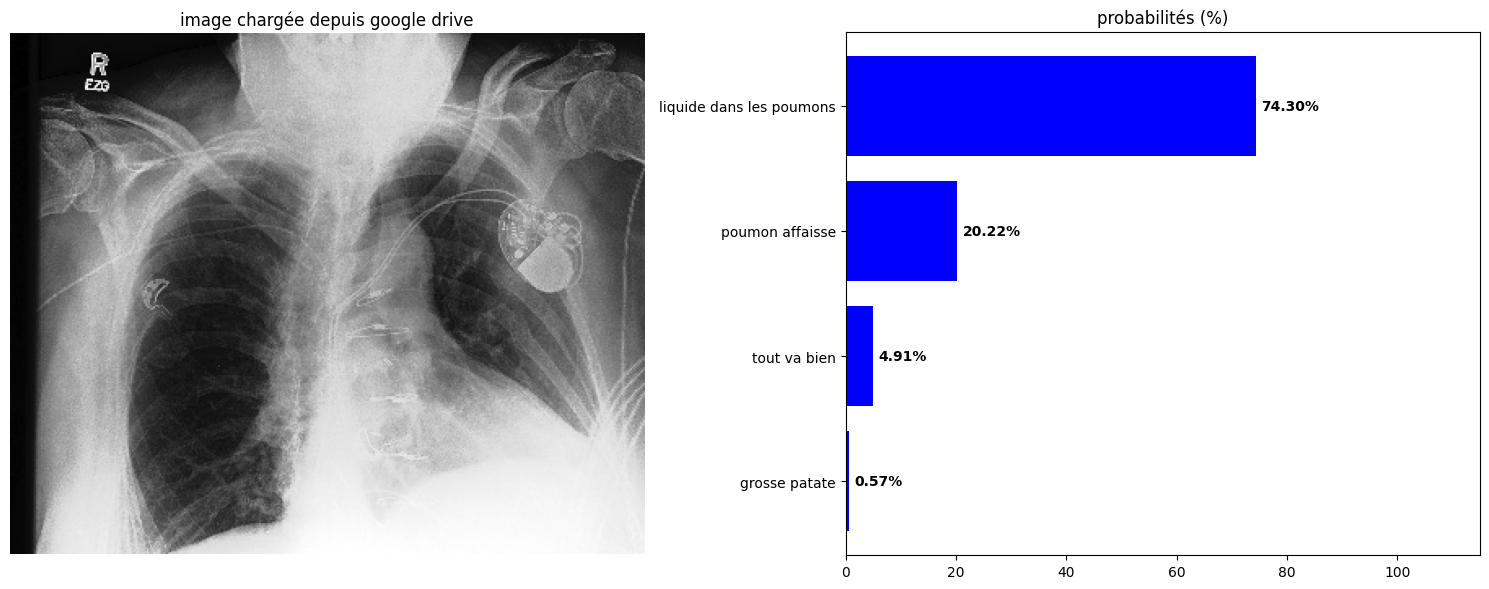

In [25]:
choix = ["grosse patate", "liquide dans les poumons", "tout va bien", "poumon affaisse"]
im2 = 'view1_frontal.jpg'
run_medclip_drive_analysis(im2,choix)

Nous remarquons après avoir utiliser notre dictionnaire avec des mot d'or que le modèle devient plus précis et plus tranchant sur la maladie détectée


testons le maintenant sur deux autre radiograpghie dont j'ai téléchargé sur le net et dont je connais déjà la maladie


la radio que vous avez téléchargé accompagné par le mot 'poumon affaisse' qui a été remplacé par le mot 'pleural line and collapsed lung' désigne à 75.43% la maladie 'poumon affaisse'.


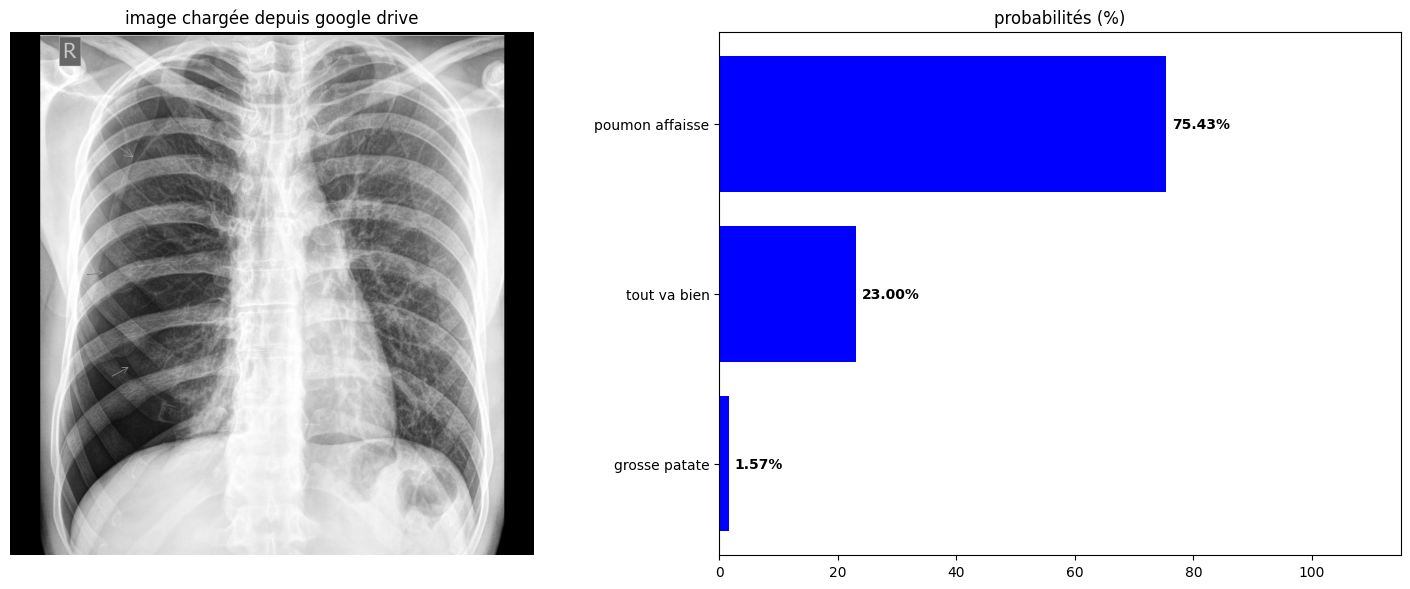

In [ ]:
#la première image est une radio d'une personne atteinte de pneumothorax
image_path_drive = "pneu.jpeg"
mes_choix = ["poumon affaisse", "tout va bien", "grosse patate"]

run_medclip_drive_analysis(image_path_drive, mes_choix)

Le résultat nous donne comme maladie poumou affaise qui est bien une autre appellation pneumothorax

Testons le modèle avec une radiographie d'une personne normale


la radio que vous avez téléchargé accompagné par le mot 'tout va bien' qui a été remplacé par le mot 'no active disease' désigne à 42.81% la maladie 'tout va bien'.


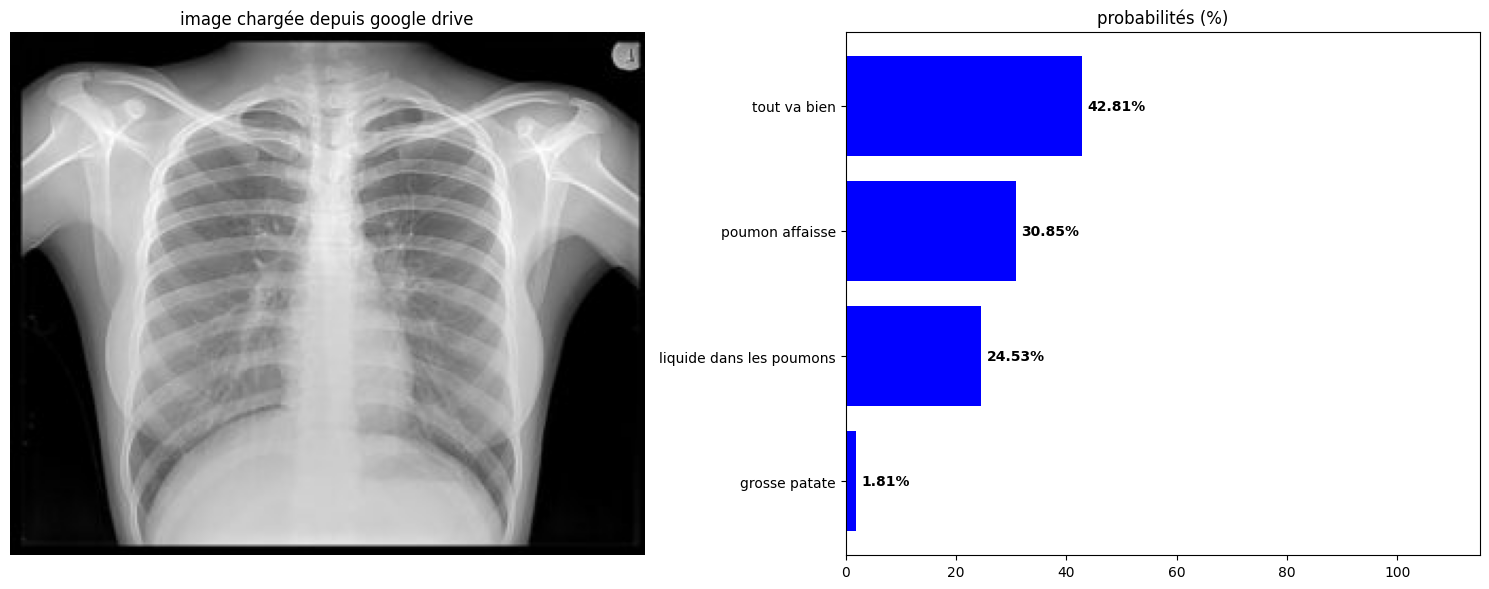

In [ ]:

nor = 'normal.jpg'
run_medclip_drive_analysis(nor,choix)